In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import display, HTML

In [2]:
import pandas as pd
credenciales_brais = pd.read_csv('rootkey.csv')
f = open('rootkey.csv', "r")
credenciales_brais = f.read().split('\n')

ACCESS_KEY = credenciales_brais[0].split('=')[1]
SECRET_KEY = credenciales_brais[1].split('=')[1]
REGION = 'eu-west-1'

In [3]:
import boto3

## nombre imagen a ofuscar:

In [4]:
nombre_imagen = 'texto1.PNG'

# Prueba S3 

In [5]:
s3 = boto3.client(
    's3',
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY, 
    region_name='eu-west-1'
)

In [6]:
print('Existing buckets:')
for bucket in s3.list_buckets()['Buckets']:
    print(f'  {bucket["Name"]}')

Existing buckets:
  pruebas.ner


In [7]:
nombre_bucket = 'pruebas.ner'
#s3.download_file(nombre_bucket, nombre_imagen, nombre_imagen)

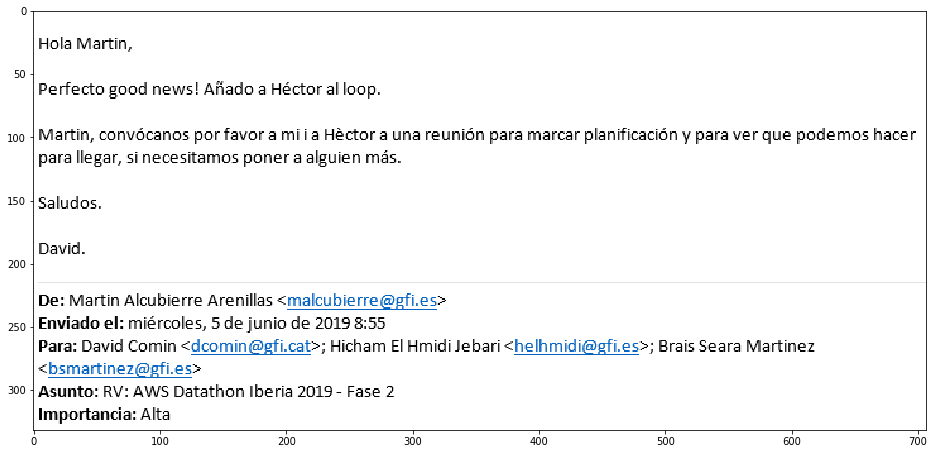

In [8]:
fig, ax = plt.subplots(1, figsize=(16, 8))
plt.imshow(plt.imread(nombre_imagen, format='png'), aspect='equal')

In [9]:
#import base64
#with open(object_name, "rb") as image_file:
#    encoded_string = base64.b64encode(image_file.read())

# Prueba textract

In [10]:
textract = boto3.client(
    'textract',
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY, 
    region_name='eu-west-1'
)

In [11]:
output_textract = textract.detect_document_text(
Document={
        #'Bytes': encoded_string#,
        'S3Object': {
            'Bucket': 'pruebas.ner',
            'Name': nombre_imagen#,
            #'Version': 'string'
        }
    }
)
output_textract

{'DocumentMetadata': {'Pages': 1},
 'Blocks': [{'BlockType': 'PAGE',
   'Geometry': {'BoundingBox': {'Width': 1.0,
     'Height': 1.0,
     'Left': 0.0,
     'Top': 0.0},
    'Polygon': [{'X': 5.750816375330785e-17, 'Y': 0.0},
     {'X': 1.0, 'Y': 2.6115960704738963e-16},
     {'X': 1.0, 'Y': 1.0},
     {'X': 0.0, 'Y': 1.0}]},
   'Id': '3ab24eb3-428f-4bee-a02a-bb2b807c1cb6',
   'Relationships': [{'Type': 'CHILD',
     'Ids': ['883a7331-7277-4af0-a8c5-a94e96ecf5f7',
      '9a031cbd-05ab-46b4-b602-74be9f26b198',
      '21957c07-441a-4895-a0c0-3b7a15c7b5b7',
      '57c98e16-60e1-42e3-976d-65bc830c9edb',
      '282bb5f7-a8ea-4d9e-b413-d495441dc4da',
      '52f228dc-93cc-47d8-a7cb-2a103c9f6b13',
      '2c2f0fac-c020-4484-b926-247e87ca956b',
      '6c61bd49-68ce-4a74-8032-fe1d71b5332f',
      '81047080-c0f6-4dd4-a3a6-b1855f3889a4',
      '4681ef28-de91-4783-bdb4-9526812be4b9',
      'ecdb6dd9-b0b0-4a24-bf5f-9ffbfc043055',
      'a68b2d1b-e657-4865-9d92-593805d2857f',
      '11bb800d-c319-4e4

In [12]:
output_textract['Blocks'][15]

{'BlockType': 'WORD',
 'Confidence': 99.93276977539062,
 'Text': 'Martin,',
 'Geometry': {'BoundingBox': {'Width': 0.06585083901882172,
   'Height': 0.042942844331264496,
   'Left': 0.047494955360889435,
   'Top': 0.06187774986028671},
  'Polygon': [{'X': 0.047494955360889435, 'Y': 0.06187774986028671},
   {'X': 0.11334579437971115, 'Y': 0.06187774986028671},
   {'X': 0.11334579437971115, 'Y': 0.10482059419155121},
   {'X': 0.047494955360889435, 'Y': 0.10482059419155121}]},
 'Id': '3644963e-fcfd-469d-aaf3-01f87ba5620c'}

# Prueba Ofuscar en Imagen 

In [13]:
from PIL import Image, ImageDraw

In [14]:
pol = output_textract['Blocks'][15]['Geometry']['Polygon']   #Martin

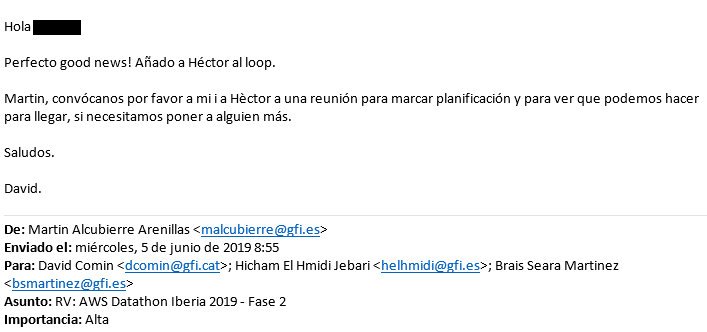

In [15]:
im = Image.open(nombre_imagen)
dr = ImageDraw.Draw(im)

xpixels = im.size[0]
ypixels = im.size[1]

a = (pol[0]['X']*(xpixels), pol[0]['Y']*(ypixels))
b = (pol[1]['X']*(xpixels), pol[1]['Y']*(ypixels))
c = (pol[2]['X']*(xpixels), pol[2]['Y']*(ypixels))
d = (pol[3]['X']*(xpixels), pol[3]['Y']*(ypixels))

#line_color = (0, 0, 255)
#dr.line([a, b, c, d, a], fill=line_color, width=2)

dr.polygon([a, b, c, d, a], fill='black')
im

# Obtener texto completo de textract

In [16]:
texto_completo = ""
BlockType = "LINE"
i = 1
n_lineas = -1
while BlockType == "LINE":
    n_lineas = n_lineas + 1
    texto_completo = texto_completo + output_textract['Blocks'][i]['Text'] + "\n"
    BlockType = output_textract['Blocks'][i]['BlockType']
    i = i + 1
texto_completo = texto_completo[0:(len(texto_completo)-len(texto_completo.split()[len(texto_completo.split())-1]))-1]
print(texto_completo)

Hola Martin,
Perfecto good news! Afado a Hector al loop.
Martin, convocanos por favor a mi i a Hector a una reunion para marcar planificacion y para ver que podemos
hacer
para llegar, si necesitamos poner a alguien mas.
Saludos.
David.
De: Martin Alcubierre Arenillas <malcubierre @gfi.es>
Enviado el: miercoles, 5 de junio de 2019 8:55
Para: David Comin <dcomin@gfi.cat>; Hicham El Hmidi Jebari <helhmidi@gfi.es>; Brais Seara Martinez
<bsmartinez@gfi.es>
Asunto: RV: AWS Datathon iberia 2019 - Fase 2
Importancia: Alta



In [17]:
n_lineas

13

# Prueba comprehend

In [18]:
comprehend = boto3.client(
    'comprehend',
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY, 
    region_name='eu-west-1'
)

In [20]:
output_comprehend = comprehend.detect_entities( 
    LanguageCode='es',    
    Text=texto,
    )

In [21]:
entidades = output_comprehend['Entities']
entidades[1]

{'Score': 0.9718290567398071,
 'Type': 'PERSON',
 'Text': 'Hector',
 'BeginOffset': 41,
 'EndOffset': 47}

In [373]:
def marcar_entidades(entidades, ocultar = False, dp = True):
    texto = texto_completo#.replace("&","&amp").replace("<","&lt").replace(">","&gt").replace("\"","&quot")
    def tag_to_background_color_en(argument):
        if ocultar == True:
            switcher = {
                'PERSON' : 'black',
                'LOCATION' : 'black',
                'OTHER' : 'black',
                'DATE' : 'white'
            }
        else:
            switcher = {
                'PERSON' : 'red',
                'LOCATION' : 'orange',
                'OTHER' : 'yellow',
                'DATE' : 'white'
        }
        return switcher.get(argument, "white")

    html = texto[0:entidades[0]['BeginOffset']]+'<span style = "background-color: ' + tag_to_background_color_en(entidades[0]['Type']) + ';">' + texto[entidades[0]['BeginOffset']:entidades[0]['EndOffset']] + '</span>'
    for i in range(1,len(entidades)):
        html = html + texto[entidades[i-1]['EndOffset']:entidades[i]['BeginOffset']] + '<span style = "background-color: ' + tag_to_background_color_en(entidades[i]['Type']) + ';">' + texto[entidades[i]['BeginOffset']:entidades[i]['EndOffset']] + '</span>'
    html = html + texto[entidades[len(entidades)-1]['EndOffset']:len(texto)]
    if dp == True:
        display(HTML(html))
    return html
html = marcar_entidades(entidades, False)

# Sacar indice de palabra por posicion caracteres
#### (porque comprehend da posiciones de caracteres y textract saca bloques de palabras)

In [203]:
import re

In [24]:
indice_palabra = 5
output_textract['Blocks'][n_lineas + indice_palabra]

{'BlockType': 'WORD',
 'Confidence': 59.93553924560547,
 'Text': 'news!',
 'Geometry': {'BoundingBox': {'Width': 0.05700817331671715,
   'Height': 0.0392625518143177,
   'Left': 0.13241243362426758,
   'Top': 0.16872864961624146},
  'Polygon': [{'X': 0.13241243362426758, 'Y': 0.16872864961624146},
   {'X': 0.18942059576511383, 'Y': 0.16872864961624146},
   {'X': 0.18942059576511383, 'Y': 0.20799119770526886},
   {'X': 0.13241243362426758, 'Y': 0.20799119770526886}]},
 'Id': '957bc502-bf4c-4b51-bac2-ff9dac51944e'}

In [25]:
texto

'Hola Martin,\nPerfecto good news! Afado a Hector al loop.\nMartin, convocanos por favor a mi i a Hector a una reunion para marcar planificacion y para ver que podemos\nhacer\npara llegar, si necesitamos poner a alguien mas.\nSaludos.\nDavid.\nDe: Martin Alcubierre Arenillas <malcubierre @gfi.es>\nEnviado el: miercoles, 5 de junio de 2019 8:55\nPara: David Comin <dcomin@gfi.cat>; Hicham El Hmidi Jebari <helhmidi@gfi.es>; Brais Seara Martinez\n<bsmartinez@gfi.es>\nAsunto: RV: AWS Datathon iberia 2019 - Fase 2\nImportancia: Alta\n'

In [26]:
i_entidad = 5
texto[entidades[i_entidad]['BeginOffset']:entidades[i_entidad]['EndOffset']]

'Martin Alcubierre'

In [27]:
inicial= 13
final = 21
texto[inicial:final]

'Perfecto'

In [28]:
posicion_caracter_inicial = inicial
texto[posicion_caracter_inicial:(posicion_caracter_inicial+len(texto[posicion_caracter_inicial:].split()[0]))]

'Perfecto'

In [29]:
def Palabra_por_posicion_caracter_inicial(posicion_caracter_inicial):
    return texto[posicion_caracter_inicial:(posicion_caracter_inicial+len(texto[posicion_caracter_inicial:].split()[0]))]
Palabra_por_posicion_caracter_inicial(posicion_caracter_inicial)

'Perfecto'

In [30]:
def Indice_palabra_por_posicion_caracter_inicial(posicion_caracter_inicial):
    splitted_texto = re.split('\n| ',texto)
    posicion_caracter_inicial = posicion_caracter_inicial
    contador_posiciones_caracteres = 0
    indice_palabra = 0
    primero = True
    while contador_posiciones_caracteres < posicion_caracter_inicial:
        contador_posiciones_caracteres = contador_posiciones_caracteres + len(splitted_texto[indice_palabra])
        if primero == True:
            primero = False
        else:
            contador_posiciones_caracteres = contador_posiciones_caracteres + 1
        indice_palabra = indice_palabra + 1
    return indice_palabra 
output_textract['Blocks'][Indice_palabra_por_posicion_caracter_inicial(inicial) + n_lineas]['Text']

'Perfecto'

# Ofuscar en la propia Imagen el resultado de comprehend

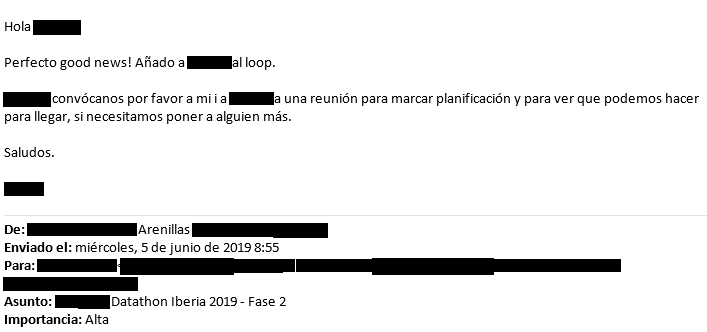

In [31]:
im = Image.open(nombre_imagen)

xpixels = im.size[0]
ypixels = im.size[1]

i_ = 0

for i in range(0,len(entidades)):
    
    n_tokens_entidad = len(entidades[i_]['Text'].split())
    
    dr = ImageDraw.Draw(im)

    if entidades[i_]['Type'] not in ('PERSON','OTHER','LOCATION') :
        i_ = i_+ 1
        continue
    
    j0_bloque = Indice_palabra_por_posicion_caracter_inicial(entidades[i_]['BeginOffset']) + n_lineas
    
    for j_bloque in range(j0_bloque,j0_bloque + n_tokens_entidad):          

        pol = output_textract['Blocks'][j_bloque]['Geometry']['Polygon']

        a = (pol[0]['X']*(xpixels), pol[0]['Y']*(ypixels))
        b = (pol[1]['X']*(xpixels), pol[1]['Y']*(ypixels))
        c = (pol[2]['X']*(xpixels), pol[2]['Y']*(ypixels))
        d = (pol[3]['X']*(xpixels), pol[3]['Y']*(ypixels))

        dr.polygon([a, b, c, d, a], fill='black')
        
    i_ = i_+ 1
im.save(nombre_imagen.split(".")[0] + "_ofuscada.PNG", "PNG")
im

# Corregir a comprehend

In [366]:
from IPython.display import Javascript
file = open(nombre_imagen.split(".")[0] + ".txt", "w")
file.write(texto_completo) 
file.close()

In [367]:
def insertar_entidad_en_su_sitio(entidad):
    ini_new = entidad['BeginOffset']
    end_new = entidad['EndOffset']
    for i in range(0,len(entidades_)-1):
        ini_old = entidades_[i]['BeginOffset']
        ini_old_next = entidades_[i+1]['BeginOffset']
        end_old = entidades_[i]['EndOffset']
        
        if ini_new <= ini_old and end_new >= end_old:
            del entidades_[i]
            entidades_.insert(i, entidad)
            return
        elif ini_new > end_old-1 and end_new < ini_old_next:
            entidades_.insert(i+1, entidad)
            return    
    entidades_.append(entidad)
    
def eliminar_entidad(ini,end):
    for i in range(0,len(entidades_)):
        if entidades_[i]['BeginOffset'] >= ini and entidades_[i]['EndOffset'] <= end:
            del entidades_[i]
            i = i - 1       

In [384]:
def set_html():
    js_file = open("js_GET_POS_NM.html","r")
    js = js_file.read()
    html = marcar_entidades(entidades_, ocultar = False, dp = False)
    js = js.replace("[MI_TEXTO]",html.replace("\n"," <br>"))  # espacio antes de <br> !! 
    temp_file = open("temp.html","w")
    temp_file.write(js) 
    temp_file.close()

In [391]:
entidades_ = entidades.copy()

In [395]:
set_html()
HTML(open("temp.html").read())